In [1]:
import pandas as pd
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import monotonically_increasing_id, udf
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")

import schemas
import tools

# 1.Methods
## load

In [2]:
def load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def load_parquet_from_weather_toPandas(path, schema:StructType = None):
    """
    load apache parquet file
    """
    weather = load_parquet(path) \
                    .withColumnRenamed("__index_level_0__", "TIME") \
                    .dropna() \
                    .withColumn("id", monotonically_increasing_id())
    weather.createOrReplaceTempView("weather_temp")
    weather_dic = spark.sql("select * from weather_temp where id in (select max(id) as id from weather_temp group by TIME)").toPandas()
    return weather_dic

def load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    # return sqlContext.read.schema(schema).csv(path, sep=";", header=True, schema=schema) if schema is not None else sqlContext.read.schema(schema).csv(path, sep=";", header=True)
    return sqlContext.read.csv(path, sep=";", header=True, schema=schema)


## UDF

In [3]:
def udf_by_grid(df:pd.DataFrame, type = DoubleType()):
    return udf(lambda g, t: list(df[df['TIME'] == t][g])[0], type)

def udf_by_ws():
    schema = StructType([
        StructField("u_interp", DoubleType(), True),
        StructField("v_interp", DoubleType(), True)
    ])
    return udf(lambda s1, d1, s2, d2, z: tools.wind_interp(s1, d1, s2, d2, z), schema)

def udf_by_tmp():
    schema = StructType([
        StructField("tmp_interp", DoubleType(), True),
    ])
    return udf(lambda t1, t2, z: tools.tmp_interp(t1, t2, z), schema)

In [4]:
def udf_regist():
    udf_type = udf(lambda x: {"H": 1, "W": 2, "P": 3, "M": 4}.get(x, 0))
    udf_hour = udf(lambda x: int(x[11:13]), IntegerType())
    udf_placement = udf(lambda x: 1.0 if x == 'LAND' else 2.0, DoubleType())
    udf_ws10  = udf_by_grid(ws10_dic, DoubleType())
    udf_ws100  = udf_by_grid(ws100_dic, DoubleType())
    udf_wd10  = udf_by_grid(wd10_dic, IntegerType())
    udf_wd100  = udf_by_grid(wd100_dic, IntegerType())
    # udf_tmp2  = udf_by_grid(tmp2_dic, IntegerType())
    # udf_tmp100  = udf_by_grid(tmp100_dic, IntegerType())
    udf_ws_interp  = udf_by_ws()
    # udf_tmp_interp  = udf_by_tmp()
    return udf_type, udf_hour, udf_placement, udf_ws10, udf_ws100, udf_wd10, udf_wd100, udf_ws_interp

## Aggregate

In [10]:
def aggregate(df, join_df):
    df = df.join(join_df, on="GSRN") \
                    .select("GSRN", "TIME_CET", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "VAERDI", "grid")

    df = df.withColumn("hour", udf_hour(df.TIME_CET)) \
                .withColumn("placement", udf_placement(df.Placement)) \
                .withColumn("ws10", udf_ws10(df.grid, df.TIME_CET)) \
                .withColumn("ws100", udf_ws100(df.grid, df.TIME_CET)) \
                .withColumn("wd10", udf_wd10(df.grid, df.TIME_CET)) \
                .withColumn("wd100", udf_wd100(df.grid, df.TIME_CET))
                # .withColumn("tmp2", udf_tmp2(df.grid, df.TIME_CET)) \
                # .withColumn("tmp100", udf_tmp100(df.grid, df.TIME_CET))
    return df

# def aggregate_with_interp(df, join_df):
#     df = aggregate(df, join_df)
#     df = df.withColumn("wsCol", \
#                 udf_ws_interp(df.ws10, df.wd10, df.ws100, df.wd100, df.Navhub_height)) \
#         .withColumn("tmpCol", \
#         udf_tmp_interp(df.tmp2, df.tmp100, df.Navhub_height)) \
#                 .select("GSRN", "TIME_CET", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "VAERDI", "wsCol.u_interp", "wsCol.v_interp", "tmpCol.tmp_interp")
#     return df

def aggregate_with_interp(df, join_df):
    df = aggregate(df, join_df)
    df = df.withColumn("wsCol", \
                udf_ws_interp(df.ws10, df.wd10, df.ws100, df.wd100, df.Navhub_height)) \
                .select("GSRN", "TIME_CET", "hour", "placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "VAERDI", "wsCol.u_interp", "wsCol.v_interp")
    return df

# 2.Data Preprocessing

In [5]:
# initialise sparkContext\
spark = SparkSession.builder \
    .master("local") \
    .appName("WindTurbine") \
    .config("spark.executor.memory", "8gb") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

## Settlement

In [6]:
 # to read parquet file
settlement = load_parquet("data/ITU_DATA/settlement/2019.parquet", schemas.settlement_schema)
settlement = settlement.dropna(subset =["VAERDI"]) \
            .withColumn("VAERDI", settlement["VAERDI"].cast("double")) \
            .where("TIME_CET like '%:00:%'")
settlement.persist()

In [8]:
settlement.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- VAERDI: double (nullable = true)
 |-- TIME_CET: string (nullable = true)



## Weather
from ENetNEA

In [7]:
ws10_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_10m.parquet")
ws100_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_100m.parquet")
wd10_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_10m.parquet")
wd100_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_100m.parquet")
# tmp2_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/temperatur_2m.parquet")
# tmp100_dic = load_parquet_from_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/temperatur_100m.parquet")

In [8]:
udf_type, udf_hour, udf_placement, udf_ws10, udf_ws100, udf_wd10, udf_wd100, udf_ws_interp = udf_regist()

## Windmills

In [9]:
windmill = load_csv("data/windmill_cleaned.csv", schemas.windmills_schema)
windmill = windmill.fillna(0)
windmill.persist()

DataFrame[GSRN: string, Turbine_type: string, Parent_GSRN: string, BBR_municipal: string, Placement: string, UTM_x: string, UTM_y: string, Capacity_kw: double, Rotor_diameter: double, Navhub_height: double, grid: string, grid_in_range: string]

In [12]:
windmill.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- Turbine_type: string (nullable = true)
 |-- Parent_GSRN: string (nullable = true)
 |-- BBR_municipal: string (nullable = true)
 |-- Placement: string (nullable = true)
 |-- UTM_x: string (nullable = true)
 |-- UTM_y: string (nullable = true)
 |-- Capacity_kw: double (nullable = true)
 |-- Rotor_diameter: double (nullable = true)
 |-- Navhub_height: double (nullable = true)
 |-- grid: string (nullable = true)
 |-- grid_in_range: string (nullable = true)



# 3.ML Analysis

In [11]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

## Windmill self clustering

In [ ]:
feat_cols = ["type", "hour", "placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "u_interp", "v_interp"]
vec_assembler = VectorAssembler(inputCols=feat_cols, outputCol="features")
windmill = vec_assembler.transform(windmill).select("GSRN", "features")

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(windmill)
windmill = scalerModel.transform(windmill)

In [ ]:
cost = []
clusters = []
for k in range(10, 20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(windmill)
    cost.append(model.computeCost(windmill))
    clusters.append(k)

# Plot the cost
df_cost = pd.DataFrame(cost)
df_cost.columns = ["cost"]
df_cost.insert(0, 'cluster', clusters)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
kmean = KMeans(featuresCol='scaledFeatures', k=30, seed=1)
model = kmean.fit(windmill)
windmill = model.transform(windmill).select("GSRN", "prediction")

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(df)
    cost[k] = model.computeCost(df)

kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(dataset.select('features'))
predictions = model.transform(dataset)
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

## Single Windmills

In [ ]:
train = settlement.where("TIME_CET not like '2019-12-30%'").sample(fraction=0.00001, seed=5)
test = settlement.where("TIME_CET like '2019-12-30%'")

In [13]:
windmill_W = windmill.where("Turbine_type = 'W'")
windmill_W.persist()

DataFrame[GSRN: string, Turbine_type: string, Parent_GSRN: string, BBR_municipal: string, Placement: string, UTM_x: string, UTM_y: string, Capacity_kw: double, Rotor_diameter: double, Navhub_height: double, grid: string, grid_in_range: string]

In [14]:
train_W = aggregate_with_interp(train, windmill_W)
test_W = aggregate_with_interp(test, windmill_W)

In [26]:
train_W.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- TIME_CET: string (nullable = true)
 |-- Placement: string (nullable = true)
 |-- Capacity_kw: double (nullable = true)
 |-- Rotor_diameter: double (nullable = true)
 |-- Navhub_height: double (nullable = true)
 |-- VAERDI: double (nullable = true)
 |-- u_interp: double (nullable = true)
 |-- v_interp: double (nullable = true)
 |-- tmp_interp: double (nullable = true)



In [15]:
feat_cols = ["hour", "type", "Capacity_kw", "Rotor_diameter", "Navhub_height", "u_interp", "v_interp"]
vec_assembler = VectorAssembler(inputCols=feat_cols, outputCol="features")
train_W = vec_assembler.transform(train_W).select("GSRN","TIME_CET", "features", "VAERDI")

test_W = vec_assembler.transform(test_W).select("GSRN","TIME_CET", "features", "VAERDI")

In [16]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(train_W)
train_W = scalerModel.transform(train_W)
test_W = scalerModel.transform(test_W)

In [17]:
test_W.where("VAERDI = 0").collect()

000005527', TIME_CET='2019-12-30 22:00:00', features=DenseVector([1.0, 225.0, 27.0, 31.5, 10.236, -1.795]), VAERDI=0.0, scaledFeatures=DenseVector([12.2067, 0.1845, 0.9161, 1.5027, 1.9698, -0.4124])),
 Row(GSRN='570715000000005527', TIME_CET='2019-12-30 23:00:00', features=DenseVector([1.0, 225.0, 27.0, 31.5, 10.586, -4.059]), VAERDI=0.0, scaledFeatures=DenseVector([12.2067, 0.1845, 0.9161, 1.5027, 2.0371, -0.9326])),
 Row(GSRN='570715000000005534', TIME_CET='2019-12-30 00:00:00', features=DenseVector([1.0, 225.0, 27.0, 31.5, 8.07, 5.863]), VAERDI=0.0, scaledFeatures=DenseVector([12.2067, 0.1845, 0.9161, 1.5027, 1.553, 1.347])),
 Row(GSRN='570715000000005534', TIME_CET='2019-12-30 01:00:00', features=DenseVector([1.0, 225.0, 27.0, 31.5, 8.574, 6.229]), VAERDI=0.0, scaledFeatures=DenseVector([12.2067, 0.1845, 0.9161, 1.5027, 1.65, 1.4311])),
 Row(GSRN='570715000000005534', TIME_CET='2019-12-30 02:00:00', features=DenseVector([1.0, 225.0, 27.0, 31.5, 7.69, 6.006]), VAERDI=0.0, scaledFeat

In [18]:
kmean = KMeans(featuresCol='scaledFeatures', k=60)

In [19]:
model = kmean.fit(train_W)
pred_avg = model.transform(train_W).groupBy("prediction").avg("VAERDI").select("prediction", "avg(VAERDI)")
pred_test = model.transform(test_W).select("GSRN","TIME_CET","prediction", "VAERDI")

In [ ]:
pred_agged.show(5)

In [46]:
import pyspark.sql.functions as sf
result = pred_test.join(pred_avg, on="prediction") \
        .groupby("TIME_CET") \
        .agg(sf.sum("avg(VAERDI)").alias("predicted"), sf.sum("VAERDI").alias("truth")) \
        .orderBy("TIME_CET") \
        .select("TIME_CET","predicted","truth")

In [21]:
pred_test.join(pred_avg, on="prediction").where("prediction = 1").collect()

042188', TIME_CET='2019-12-30 03:00:00', VAERDI=85.0, avg(VAERDI)=103.93484000000001),
 Row(prediction=1, GSRN='570715000000047824', TIME_CET='2019-12-30 00:00:00', VAERDI=66.0, avg(VAERDI)=103.93484000000001),
 Row(prediction=1, GSRN='570715000000035623', TIME_CET='2019-12-30 03:00:00', VAERDI=98.4, avg(VAERDI)=103.93484000000001),
 Row(prediction=1, GSRN='570715000000048074', TIME_CET='2019-12-30 02:00:00', VAERDI=99.0, avg(VAERDI)=103.93484000000001),
 Row(prediction=1, GSRN='570715000000028649', TIME_CET='2019-12-30 06:00:00', VAERDI=0.0, avg(VAERDI)=103.93484000000001),
 Row(prediction=1, GSRN='570715000000028649', TIME_CET='2019-12-30 07:00:00', VAERDI=0.0, avg(VAERDI)=103.93484000000001),
 Row(prediction=1, GSRN='570715000000047879', TIME_CET='2019-12-30 00:00:00', VAERDI=64.0, avg(VAERDI)=103.93484000000001),
 Row(prediction=1, GSRN='570715000000048036', TIME_CET='2019-12-30 00:00:00', VAERDI=67.0, avg(VAERDI)=103.93484000000001),
 Row(prediction=1, GSRN='570715000000048036', T

In [47]:
data = result.toPandas()

In [48]:
import seaborn as sns

In [49]:
data.head()

,TIME_CET,predicted,truth
0,2019-12-30 00:00:00,397905.132218,902708.544
1,2019-12-30 01:00:00,397905.132218,966054.304
2,2019-12-30 02:00:00,397905.132218,933863.691
3,2019-12-30 03:00:00,397905.132218,917077.173
4,2019-12-30 04:00:00,397905.132218,985483.482


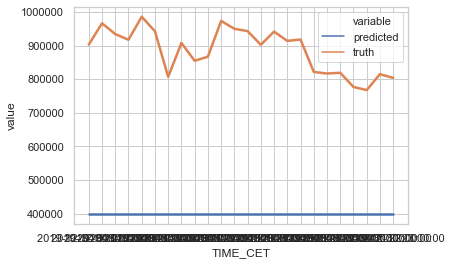

In [50]:
sns.set(style="whitegrid")
sns.lineplot(x="TIME_CET", y="value", data=pd.melt(data, ['TIME_CET']), hue='variable',linewidth=2.5)